In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
#import and clean up data
growth_data = pd.read_csv('Data/230623 BHET growth curve.csv',skiprows = 6)
#remove superfluous columns
growth_data = growth_data.drop(labels = ['Unnamed: 1','Time'],axis=1)
#replace labels
colnames = list(growth_data.columns)
colnames[0] = 'Sample'
growth_data.columns = colnames
growth_data = growth_data.replace(to_replace='A',value='BHET')
growth_data = growth_data.replace(to_replace='B',value='MHET')
growth_data = growth_data.replace(to_replace='C',value='Glucose')
growth_data = growth_data.replace(to_replace='D',value='Control')
#drop rows where values are <0.1 which are empty on the plate
growth_data = growth_data.loc[growth_data['0 h '] > 0.1]
mean_growth_data = growth_data.groupby('Sample').mean()

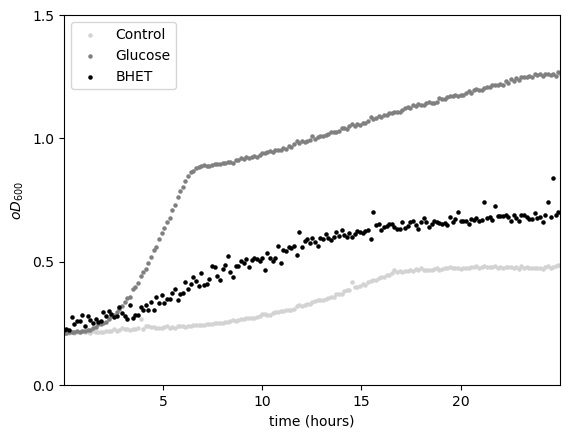

In [3]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["lightgray", "gray", "black"])

fig,ax = plt.subplots()

x = range(0,mean_growth_data.shape[1]*8,8)

for sample in ['Control','Glucose','BHET']:
    ax.scatter(x,mean_growth_data.loc[sample].values,s = 5,label=sample)
ax.set_xlim((0,1500))
ax.set_ylim((0,1.5))
ax.set_yticks([0,0.5,1,1.5])
ax.set_xticks([300,600,900,1200])
ax.set_xticklabels([5,10,15,20])
ax.set_xlabel('time (hours)')
ax.set_ylabel(r"$oD_{600}$")
ax.legend()
#plt.savefig('BHET_growth.svg')
plt.show()

In [4]:
endpoints = pd.read_csv('Data/231020 Carbon Source Tests.csv')
endpoints['increase'] = endpoints['oD t48'] / endpoints['oD t0']
endpoints.head()

,Date,Sample,oD t0,oD t48,increase
0,230901,BHET,328,486.000000,1.481707
1,230901,EG,492,654.000000,1.329268
2,230901,DMSO,437,386.000000,0.883295
3,230904,BHET,300,650.000000,2.166667
4,230904,TPA,300,445.333333,1.484444


In [5]:
increase = endpoints.groupby('Sample').mean()['increase']
sterr = endpoints.groupby('Sample').sem()['increase']
summary = pd.concat([increase,sterr], axis = 1)
summary.columns = ['mean','s.e.m.']
summary=summary.reindex(['BHET','TPA','EG','DMSO','Glucose'])
summary = summary.reset_index()
summary

,Sample,mean,s.e.m.
0,BHET,2.029675,0.181934
1,TPA,1.484444,0.406852
2,EG,1.376965,0.041651
3,DMSO,1.136659,0.098944
4,Glucose,38.436667,4.911251


In [6]:
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

#drop glucose values from dataset
endpoints = endpoints.loc[endpoints['Sample']!='Glucose']

one_way_anova = ols('increase ~ Sample',data=endpoints).fit()
sm.stats.anova_lm(one_way_anova,type=2)

,df,sum_sq,mean_sq,F,PR(>F)
Sample,3.0,2.138264,0.712755,3.713765,0.035277
Residual,15.0,2.878836,0.191922,NaN,NaN


In [7]:

tukey = pairwise_tukeyhsd(endog=endpoints['increase'],
                          groups=endpoints['Sample'],
                          alpha=0.05)
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  BHET   DMSO   -0.893 0.0261 -1.6916 -0.0945   True
  BHET     EG  -0.6527 0.1293 -1.4513  0.1459  False
  BHET    TPA  -0.5452 0.2875 -1.3922  0.3018  False
  DMSO     EG   0.2403 0.8214 -0.5583  1.0389  False
  DMSO    TPA   0.3478  0.646 -0.4992  1.1948  False
    EG    TPA   0.1075 0.9826 -0.7395  0.9545  False
----------------------------------------------------


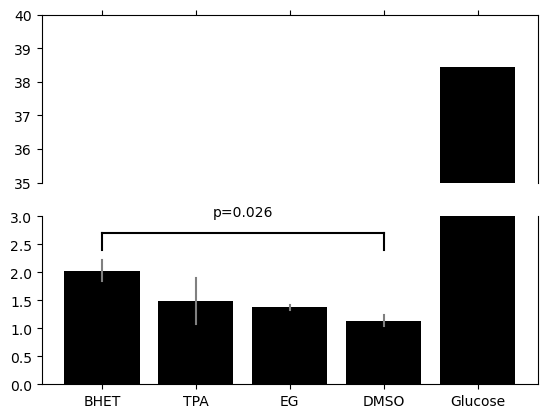

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.2)
#plot values on broken axes
ax1.bar(summary['Sample'],summary['mean'],color = 'black')
ax2.bar(summary['Sample'],summary['mean'],color = 'black')
for idx,eb in enumerate(['BHET','TPA','EG','DMSO']):
    row = summary.loc[summary['Sample']==eb]
    bottom = row['mean'].values[0] - row['s.e.m.'].values[0]
    top = row['mean'].values[0] + row['s.e.m.'].values[0]
    ax1.plot((idx,idx),(bottom,top),color='grey')
    ax2.plot((idx,idx),(bottom,top),color='grey')
ax1.set_ylim(35, 40)  
ax2.set_ylim(0, 3)  
#add stats information
ax2.plot((0,0),(2.4,2.7),color='black')
ax2.plot((0,3),(2.7,2.7),color='black')
ax2.plot((3,3),(2.4,2.7),color='black')
ax2.text(1.5,3,'p=0.026',horizontalalignment='center')
#adjust the axis properties to make sense of the borken axis
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False) 
ax2.xaxis.tick_bottom()
#plt.savefig('Carbon Sources Endpoint Assay.svg')
plt.show()